# CS6120 Project: Doctor Note Diagnosis Classification

## Data Import and Cleaning

In [1]:
import pickle
import re
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import nltk
from nltk.corpus import stopwords

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from gensim.models import FastText
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D, AveragePooling1D, Concatenate, LeakyReLU
from keras.utils.vis_utils import plot_model
import pydot
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument

Using TensorFlow backend.


In [ ]:

diagnoses_ICD = pd.read_csv('DIAGNOSES_ICD.csv.gz', compression='gzip',
                   error_bad_lines=False)
diagnoses_ICD.head()

In [ ]:
value=list(zip(list(diagnoses_ICD.SUBJECT_ID),list(diagnoses_ICD.HADM_ID)))

In [ ]:
value=list(set(value))

In [ ]:
diagnoses=[]
for v in tqdm(value):
    x=diagnoses_ICD[(diagnoses_ICD['SUBJECT_ID'] == v[0]) & (diagnoses_ICD['HADM_ID'] ==v[1]) ]
    t=x.sample(1).values
    t=list(t[0])
    diagnoses.append(t)


In [ ]:
diagnoses_df=pd.DataFrame(diagnoses,columns=diagnoses_ICD.columns)

In [ ]:
NOTEEVENTS = pd.read_csv('NOTEEVENTS.csv.gz',compression='gzip',
                   error_bad_lines=False,low_memory=False)

In [ ]:
NOTEEVENTS_trim=NOTEEVENTS[['SUBJECT_ID','HADM_ID','TEXT']]

In [ ]:
merged_data=NOTEEVENTS_trim.merge(diagnoses_df,how='left')
merged_data=merged_data.dropna()

In [ ]:
merged_clean_trim=merged_data[['TEXT','ICD9_CODE']]
merged_clean_trim=merged_clean_trim.dropna()

In [ ]:
g=dict(merged_clean_trim['ICD9_CODE'].value_counts())

In [ ]:
removeable_icd9codes=[]
keep_icd9codes=[]
for key,value in g.items():
    if value<=15000:
        removeable_icd9codes.append(key)
    else:
        keep_icd9codes.append(key)

In [ ]:
merged_clean_trim_reduced=merged_clean_trim[merged_clean_trim.ICD9_CODE.isin(keep_icd9codes)].reset_index()

In [ ]:
merged_clean_trim_reduced=merged_clean_trim_reduced[['TEXT','ICD9_CODE']]

In [ ]:
merged_clean_trim_reduced.to_pickle('final_dataframe.pickle')

In [ ]:
merged_clean_trim_reduced=pd.read_pickle('final_dataframe.pickle')

In [ ]:
merged_clean_trim_reduced.shape

## Feature Engineering 

In [ ]:
def text_clean(notes):
    cleannotes=[]
    for i in tqdm(range(notes.shape[0])):
        text=notes.iloc[i].values.tolist()[0]
        text = re.sub("[!@#$+%*:()'-]", ' ', text)
        #text = re.sub('  ',' ',text)
        text = re.sub('\[',' ',text)
        text = re.sub('\]',' ',text)
        text = re.sub('\n\n\n', ' ',text)
        text = re.sub('\n\n', ' ',text)
        text = re.sub('\n',' ',text)
        text = re.sub('      ',' ',text)
        text = re.sub('   ',' ',text)
        text = re.sub('  ',' ',text)
        text = re.sub('  ',' ',text)
        text = re.sub('\/',' ',text)
        cleannotes.append(text)
        
    return(cleannotes)

In [ ]:
x=text_clean(merged_clean_trim_reduced)

In [ ]:
merged_clean_trim_reduced['cleaned_notes']=x

In [ ]:
ICD9CODE_class=[]
for i in tqdm(range(merged_clean_trim_reduced.shape[0])):
    if merged_clean_trim_reduced.iloc[i].values.tolist()[1] in ['4019', '42731', '41401', '4280', '51881']:
        ICD9CODE_class.append('Cardio_Issues')
    elif merged_clean_trim_reduced.iloc[i].values.tolist()[1] in ['V3001','769','77081']:
        ICD9CODE_class.append('NewBorn_Issue')
    elif merged_clean_trim_reduced.iloc[i].values.tolist()[1] in ['5990','486','V290','7742','V053']:
        ICD9CODE_class.append('Infection')
    elif merged_clean_trim_reduced.iloc[i].values.tolist()[1] in ['25000', '2859']:
        ICD9CODE_class.append('Disease')
    elif merged_clean_trim_reduced.iloc[i].values.tolist()[1] in ['5849']:
        ICD9CODE_class.append('Kidney Failure')
    else: 
        print(merged_clean_trim_reduced.iloc[i].values.tolist()[1])

In [ ]:
merged_clean_trim_reduced['ICD9_CLASS']=ICD9CODE_class

In [ ]:
merged_clean_trim_reduced.head()

In [ ]:
merged_clean_trim_reduced.to_pickle('final_dataframe.pickle')

In [2]:
merged_clean_trim_reduced=pd.read_pickle('final_dataframe.pickle')

In [3]:
train, test = train_test_split(merged_clean_trim_reduced, test_size=0.3, random_state=42)
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return (tokens)


In [4]:
train=train.sample(2000)
test=test.sample(100)

In [5]:
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['cleaned_notes']), tags=[r.ICD9_CLASS]), axis=1)


In [6]:
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['cleaned_notes']), tags=[r.ICD9_CLASS]), axis=1)

In [7]:
import multiprocessing
cores = multiprocessing.cpu_count()
model = Doc2Vec(train_tagged, vector_size=300, window=2, min_count=1, workers=cores)

In [8]:
train_tags=[]
train_vectors=[]
for x in tqdm(train_tagged.values):
    for doc in x:
        if len(doc)>1:
            train_vectors.append(model.infer_vector(doc).tolist())
        else:
            train_tags.append(doc[0])      

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 189.76it/s]


In [9]:
test_tags=[]
test_vectors=[]
for x in tqdm(test_tagged.values):
    for doc in x:
        if len(doc)>1:
            test_vectors.append(model.infer_vector(doc).tolist())
        else:
            test_tags.append(doc[0])  

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 172.26it/s]


In [10]:
train_df=pd.DataFrame(train_vectors)

In [11]:
test_df=pd.DataFrame(test_vectors)

## Basic Neural Network

In [54]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,activation='tanh',hidden_layer_sizes=(5, 10), max_iter=50,random_state=1)
clf.fit(train_df,train_tags)
print(clf.score(train_df,train_tags))
print(clf.score(test_df,test_tags))
y_predict=clf.predict(test_df).tolist()
a=confusion_matrix(y_predict,test_tags)

0.631
0.46


In [55]:
from sklearn.metrics import classification_report
print(classification_report(test_tags, y_predict, target_names=list(set(test_tags))))

C:\Users\noahd\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\noahd\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\noahd\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

      Disease       0.50      0.92      0.65        36
Cardio_Issues       0.00      0.00      0.00        14
NewBorn_Issue       0.35      0.48      0.41        23
    Infection       0.00      0.00      0.00         9
Kidney Failue       0.67      0.11      0.19        18

    micro avg       0.46      0.46      0.46       100
    macro avg       0.30      0.30      0.25       100
 weighted avg       0.38      0.46      0.36       100



(5.0, 0.0)

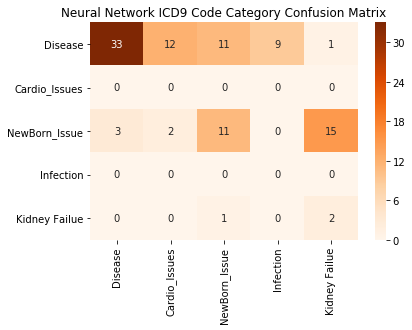

In [56]:
from pandas import DataFrame
df_cm = DataFrame(a, index=list(set(test_tags)), columns=list(set(test_tags)))
import seaborn as sn

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)
bottom, top = ax.get_ylim()
ax.set_title('Neural Network ICD9 Code Category Confusion Matrix')
ax.set_ylim(bottom + 0.5, top - 0.5)

## Random Forest

In [57]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(train_df,train_tags)
print(clf.score(train_df,train_tags))
print(clf.score(test_df,test_tags))
y_predict=clf.predict(test_df).tolist()
a=confusion_matrix(y_predict,test_tags)

0.5965
0.47


In [58]:
from sklearn.metrics import classification_report
print(classification_report(test_tags, y_predict, target_names=list(set(test_tags))))

C:\Users\noahd\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\noahd\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\noahd\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

      Disease       0.49      0.97      0.65        36
Cardio_Issues       0.00      0.00      0.00        14
NewBorn_Issue       0.43      0.52      0.47        23
    Infection       0.00      0.00      0.00         9
Kidney Failue       0.00      0.00      0.00        18

    micro avg       0.47      0.47      0.47       100
    macro avg       0.18      0.30      0.22       100
 weighted avg       0.27      0.47      0.34       100



(5.0, 0.0)

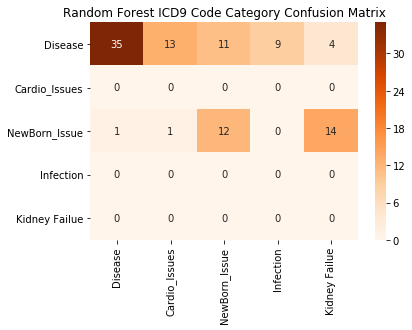

In [59]:
from pandas import DataFrame
df_cm = DataFrame(a, index=list(set(test_tags)), columns=list(set(test_tags)))
import seaborn as sn

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)
bottom, top = ax.get_ylim()
ax.set_title('Random Forest ICD9 Code Category Confusion Matrix')
ax.set_ylim(bottom + 0.5, top - 0.5)

## Gradient Boost Classifer

In [60]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=20, learning_rate=.5, max_features=10, max_depth=5, random_state=0)
clf.fit(train_df,train_tags)
print(clf.score(train_df,train_tags))
print(clf.score(test_df,test_tags))
y_predict=clf.predict(test_df).tolist()
a=confusion_matrix(y_predict,test_tags)

0.9985
0.47


In [61]:
from sklearn.metrics import classification_report
print(classification_report(test_tags, y_predict, target_names=list(set(test_tags))))

               precision    recall  f1-score   support

      Disease       0.52      0.81      0.63        36
Cardio_Issues       0.40      0.14      0.21        14
NewBorn_Issue       0.39      0.52      0.44        23
    Infection       0.00      0.00      0.00         9
Kidney Failue       0.57      0.22      0.32        18

    micro avg       0.47      0.47      0.47       100
    macro avg       0.38      0.34      0.32       100
 weighted avg       0.43      0.47      0.42       100



(5.0, 0.0)

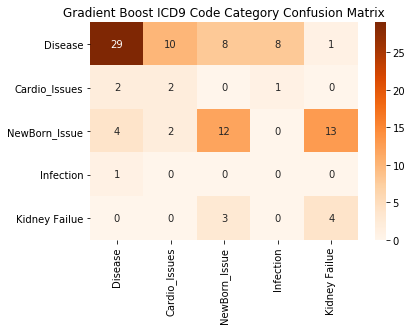

In [62]:
from pandas import DataFrame
df_cm = DataFrame(a, index=list(set(test_tags)), columns=list(set(test_tags)))
import seaborn as sn

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)
bottom, top = ax.get_ylim()
ax.set_title('Gradient Boost ICD9 Code Category Confusion Matrix')
ax.set_ylim(bottom + 0.5, top - 0.5)